In [1]:
"""Imports."""

import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

import shutil

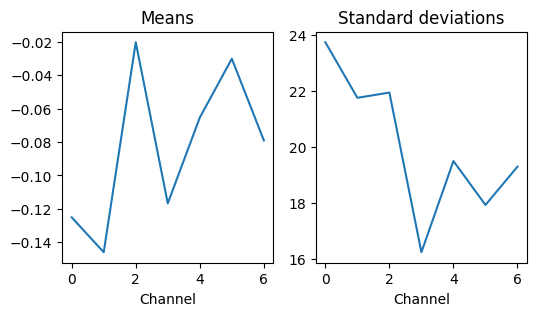

In [177]:
"""Constants."""

data_paths = [
    'data/mahdi_v0.csv',
    'data/mahdi_vb.csv',
    # 'data/mahdi_vd.csv',
    # 'data/mahdi_ve.csv',
    # 'data/mahdi_vf.csv',
    'data/mahdi_vg.csv',
    'data/mahdi_vh.csv',
]

data_arrays = [
    np.genfromtxt(x, delimiter=',', dtype=str, filling_values='')
    for x in data_paths
]
data_raw = np.concatenate(data_arrays, axis=0)
labels = data_raw[:, 0]
data_eeg_raw = data_raw[:, 1:8].astype(float)

# Plot mean and variance for each channel
means = np.nanmean(data_eeg_raw, axis=0)
stds = np.nanstd(data_eeg_raw, axis=0)
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].plot(means)
axes[0].set_xlabel('Channel')
axes[0].set_title('Means')
axes[1].plot(stds)
axes[1].set_xlabel('Channel')
axes[1].set_title('Standard deviations')

# Normalize by mean and variance
data_eeg_raw -= means[None]
data_eeg_raw /= stds[None]

In [178]:
"""Decompose data in batches."""

batch_size = 200  # Sample rate is ~450 Hz
stride = 50
unique_labels = np.unique(labels)
data_batches = {
    label: [] for label in unique_labels
}
for i in range(0, len(data_eeg_raw) - batch_size, stride):
    label_batch = labels[i: i + batch_size]
    if len(np.unique(label_batch)) == 1:
        data_batches[label_batch[0]].append(data_eeg_raw[i: i + batch_size])

for k, v in data_batches.items():
    print(f'Label: {k}, num_samples: {len(v)}')

Label: , num_samples: 802
Label: a, num_samples: 297
Label: b, num_samples: 58
Label: c, num_samples: 83
Label: w, num_samples: 15
Label: z, num_samples: 24


In [179]:
"""Apply feature extraction to batches."""

def _power_spectrum(x):
    ps = np.abs(np.fft.fft(x, n=1000))**2
    # ps = np.abs(np.fft.fft(x))**2
    time_step = 1 / 450
    freqs = np.fft.fftfreq(x.size, time_step)
    idx = np.argsort(freqs)
    indices = idx[len(idx) // 2: 180]
    indices = indices[::5]
    return ps[indices]


def _all_features(batch):
    all_features = np.concatenate(
        [np.nanstd(batch, axis=0)]
        # +
        # [_power_spectrum(x) for x in batch.T]
    )
    return all_features

# freq, power = _power_spectrum(data_batches[''][2][:, 0])
# plt.plot(freq, power)

feature_batches = {
    k: [_all_features(x) for x in v] for k, v in data_batches.items()
}
batch_labels = []
batch_features = []
for k, v in feature_batches.items():
    batch_labels.extend(len(v) * [k])
    batch_features.extend(v)
    
batch_features = np.array(batch_features)
batch_labels = np.array(batch_labels)
batch_features -= np.nanmean(batch_features, axis=0, keepdims=True)
batch_features /= np.nanstd(batch_features, axis=0, keepdims=True)
    

In [197]:
"""Compute PCA."""

from sklearn import decomposition as sklearn_decomposition

def _pca(features, n_components=3):
    pca_fit = sklearn_decomposition.PCA(n_components=n_components).fit(
        features)
    scree = np.cumsum(pca_fit.explained_variance_ratio_)
    print(f'scree: {scree[:10]}')
    
    pca_features = pca_fit.transform(features)
    return pca_fit, pca_features

selection = ['', 'b', 'c']
# selection = ['', 'w', 'z']
pca_inds = np.array([x in selection for x in batch_labels])
pca_labels = batch_labels[pca_inds]

pca_fit, pca_features = _pca(batch_features[pca_inds])

scree: [0.79999302 0.89768718 0.96065115]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['' 'b' 'c']


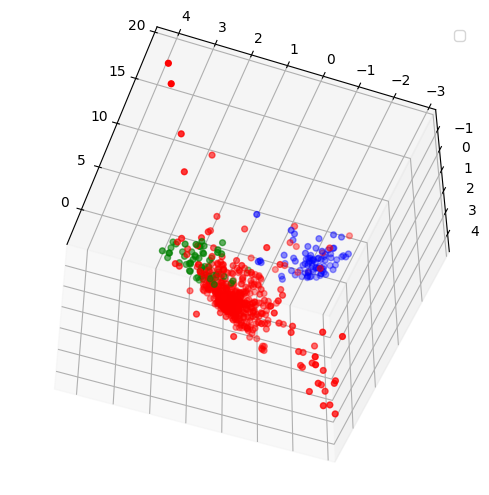

In [198]:
"""Plot PCA."""

%matplotlib inline

_COLORS = ['r', 'g', 'b', 'k']
unique_labels = np.unique(pca_labels)
print(unique_labels)
label_to_color = {label: _COLORS[i] for i, label in enumerate(unique_labels)}

_PCA_START_IND = 0
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Make figure
x = pca_features[:, _PCA_START_IND]
y = pca_features[:, _PCA_START_IND + 1]
z = pca_features[:, _PCA_START_IND + 2]
colors = [label_to_color[x] for x in pca_labels]
ax.scatter(x, y, z, marker='.', s=70, c=colors)
ax.legend()

ax.view_init(130, 200)

plt.show()

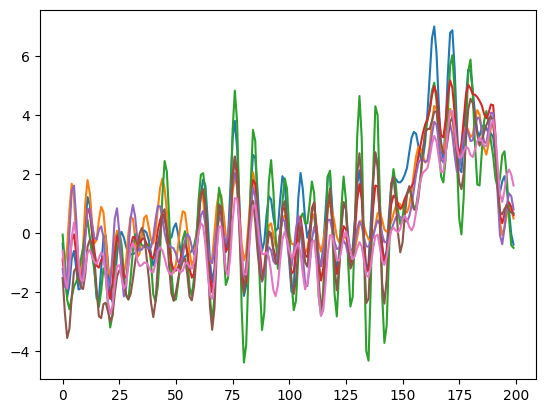

In [205]:
data_batches['b'][0].shape
plt.figure()
plt.plot(data_batches['b'][3])

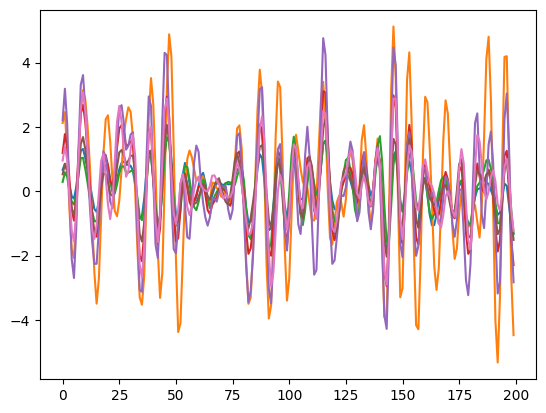

In [206]:
data_batches['c'][0].shape
plt.figure()
plt.plot(data_batches['c'][10])